In [1]:
# (Colaboratoryでの実行を想定しているので) まずGitHubレポジトリのクローンを作成する
! git clone https://github.com/lvzeyu/chss_2025_assignment.git

Cloning into 'chss_2025_assignment'...
remote: Enumerating objects: 650, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 650 (delta 135), reused 115 (delta 115), pack-reused 476 (from 3)
Receiving objects: 100% (650/650), 70.65 MiB | 21.64 MiB/s, done.
Resolving deltas: 100% (325/325), done.
Updating files: 100% (155/155), done.


In [2]:
!ls chss_2025_assignment/最終課題/Data

h27_age_df.csv	    h27_house_info_df.csv  h27_marriage_df.csv
h27_family_df.csv   h27_indusry_df.csv	   h27_work_status_df.csv
h27_gender_df2.csv  h27_job_df.csv	   income_district.csv
h27_house_df.csv    h27_labor_df.csv


In [3]:
import pandas as pd
import numpy as np

# CSVファイルを読み込む（とりあえず、予測には人口構成・世帯構成の二つのデータを使用する）

# 平均収入（＝目的変数）のデータ
income_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/income_district.csv")

# 人口構成（男女別人口・世帯数など）のデータ
gender_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/h27_gender_df2.csv")

# 世帯構成（世帯人数の分布）のデータ
family_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/h27_family_df.csv")

In [4]:
def clean_numeric_df(df, cols):
    # 欠損値の処理： "X", "-", などを to NaN に変換する関数
    for col in cols:
        df[col] = df[col].replace(["X", "-", "…", "na", "NaN"], np.nan)
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# gender_df、family_dfを（数値列を指定して）整形する
gender_numeric_cols = ['population', 'male_population', 'female_population', 'family_count']
gender_df = clean_numeric_df(gender_df, gender_numeric_cols)

family_numeric_cols = ['family_count', 'family_member_count', 'general_family_count',
                       'member_1', 'member_2', 'member_3', 'member_4', 'member_5',
                       'member_6', 'member_7']
family_df = clean_numeric_df(family_df, family_numeric_cols)



# -> gender-df, family_dfのファイルは"level-identifer"によって、地域の上位区分（1: 市区町村）と下位区分（2, 3: 町、丁目など）を管理している
# しかし、目的変数(=income)はarea_code(district-idと対応)で区別されており、これは上でいう上位区分に対応する
# よって、下位区分のデータは不要 -> 上位区分（市区町村）のみ抽出する
gender_top = gender_df[gender_df["level_identifier"] == 1].copy()
family_top = family_df[family_df["level_identifier"] == 1].copy()


# gender と family を district_idに基づいて統合
# 不要な列を削除する
family_top_trimmed = family_top.drop(columns=['state_name', 'city_name', 'district_name', 'district2_name',
                                              'level_identifier', 'district2_id'])
demographic_top = pd.merge(gender_top, family_top_trimmed, on='district_id', how='left')

# incomeデータの列名を明記しておく
income_df.columns = ['area_code', 'income_mean']

# incomeデータとdemographicをマージする
merged_df = pd.merge(income_df, demographic_top, left_on='area_code', right_on='district_id', how='left')

# pandasによって重複しているfamily_countが自動的に変換されるので、直す
merged_df = merged_df.rename(columns={
    'family_count_x': 'family_count_gender',
    'family_count_y': 'family_count_family'
})


# 欠損値を除去（目的変数が欠けている行）
merged_df = merged_df.dropna(subset=['income_mean'])

# データ構造を確認
print("📊 データ構造（サンプル）:")
print(merged_df[['area_code', 'income_mean', 'population', 'male_population', 'female_population',
                 'family_count_gender', 'family_count_family', 'family_member_count',
                 'member_1', 'member_2']].head())

📊 データ構造（サンプル）:
   area_code  income_mean  population  male_population  female_population  \
0      13228   480.984419     80954.0          40218.0            40736.0   
1      43514   439.775281     15523.0           7178.0             8345.0   
2      23237   487.507769     86898.0          43229.0            43669.0   
3      18208   505.495103     28729.0          13555.0            15174.0   
4      12238   385.423846     38594.0          18719.0            19875.0   

   family_count_gender  family_count_family  family_member_count  member_1  \
0              30817.0              30817.0              80954.0    7551.0   
1               5298.0               5298.0              15523.0    1177.0   
2              33190.0              33190.0              86898.0    8353.0   
3               9697.0               9697.0              28729.0    2359.0   
4              14849.0              14849.0              38594.0    3860.0   

   member_2  
0    9358.0  
1    1578.0  
2    9575.0

【データの構造について】

income_district.csv = 各地域の平均収入データ

h27_gender_df2.csv = 各地域の人口構成（男女別人口、世帯数など）

h27_family_df.csv = 各地域の世帯構成（世帯の構成人数）


merged_df = 整形後のデータセット
- area_code: 地域コード
- income_mean: 平均収入(目的変数)
- population: 総人口
- male_population, female_population: 男性/女性人口
- family_count_gender: 世帯数（genderより）
- family_count_family: 世帯数(familyより)
- family_member_count: 総家族人数（）
- meber1 ~ member7: 1~7人世帯の数


整形処理の内容：
- 欠損値等の処理
- 地域単位の整理（丁目など、細かい区分を除外）
- 重複列管理
- データの統合(各データをdistrict_id, area_codeに基づいて統合)


🌟統合後のデータは「1地域に対し、その特徴量が横並び」という形になっている （-> 学習に便利！）



### 【特徴を可視化する】

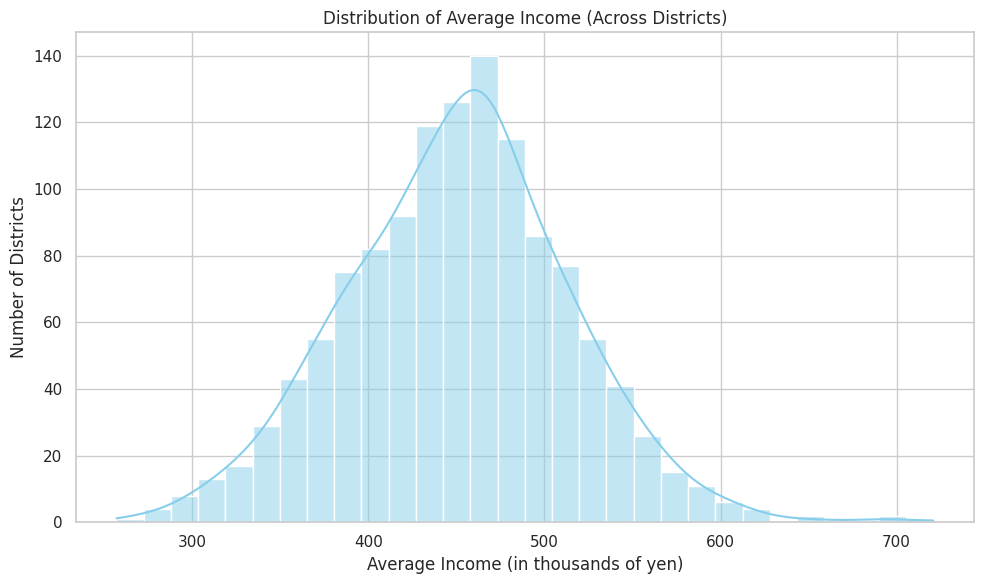

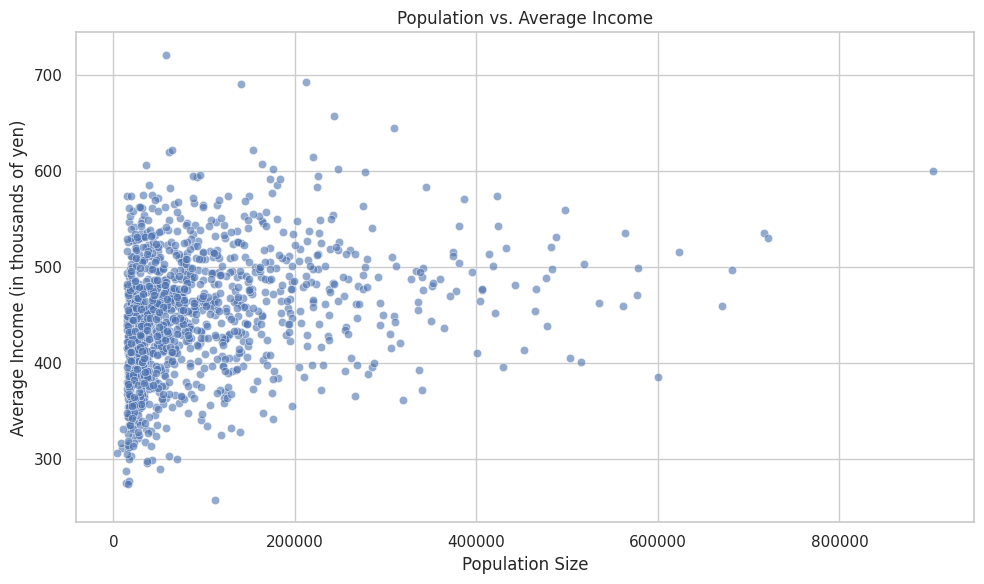

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# グラフ1: 平均所得の分布（全国）
plt.figure(figsize=(10, 6))
sns.histplot(merged_df["income_mean"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Average Income (Across Districts)")
plt.xlabel("Average Income (in thousands of yen)")
plt.ylabel("Number of Districts")
plt.tight_layout()
plt.show()

# グラフ2: 人口規模と平均所得の関係
plt.figure(figsize=(10, 6))
sns.scatterplot(x="population", y="income_mean", data=merged_df, alpha=0.6)
plt.title("Population vs. Average Income")
plt.xlabel("Population Size")
plt.ylabel("Average Income (in thousands of yen)")
plt.tight_layout()
plt.show()


（可視化の結果）

**1番目のグラフ：各地域の平均所得の全体分布。**
- 所得はおよそ400~500万円に集中している
- 正規分布に近い形（ベルカーブ）をしている （-> 回帰モデルでの予測に適している!）

**2番目のグラフ：各地域の人口と平均所得の関係**
- 人口が小さい地域（0~20万円）にデータが集中している（数の上では小規模な自治体の方が圧倒的に多い）
- 明確な相関関係はみられない（人口規模だけでは平均所得の違いを説明できない）

## **【モデルの構築・評価】**

sklearnを用いて、実際にモデルを適用・結果を評価してみる

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 関連する特徴量と目的変数（income）を選ぶ
features = [
    'population', 'male_population', 'female_population',
    'family_count_gender', 'family_count_family',
    'family_member_count', 'member_1', 'member_2', 'member_3',
    'member_4', 'member_5', 'member_6', 'member_7'
]
target = 'income_mean'

# 説明・目的変数が欠損している行は飛ばす
model_df = merged_df[features + [target]].dropna()

# データを分割
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. 線形回帰
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 2. ランダムフォレスト
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 評価のための関数
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n🔍 {model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")

# 結果を表示する
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")



🔍 Linear Regression Performance:
RMSE: 54.34
R² Score: 0.293

🔍 Random Forest Performance:
RMSE: 45.71
R² Score: 0.499


## **【結果の解釈】**
**1. 線形回帰**
- RMSE = 54.34：モデルの予測値と実際の平均所得の間には、平均しておよそ54万円の誤差がある
- R2 = 0.293：モデルがデータのばらつきの29.3%を説明している

-> 線形モデルではあまり予測精度が高くない（＝選んだ特徴量と所得の関係は非線形である）

**2. ランダムフォレスト**
- RMSE = 45.71：線形回帰に比べて、誤差は8.6万円小さくなっている
- R2 = 0.499：モデルがデータのばらつきの約50%を説明している！

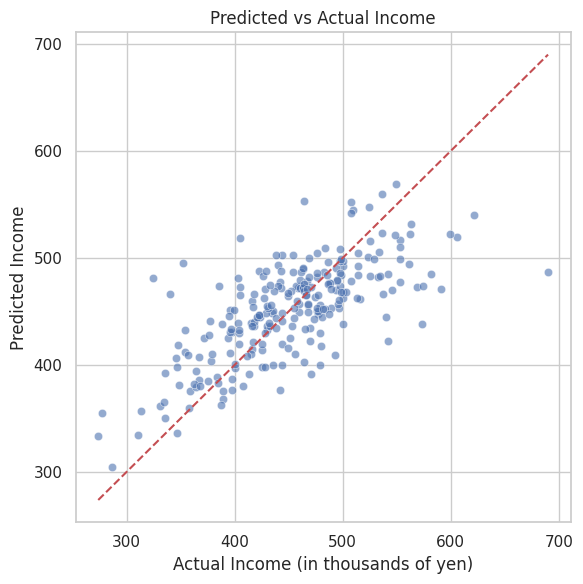

In [7]:
# 予測結果（点）と実際の値（赤い点線）を表示してみる
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 「予測値 vs 実際の値」のグラフ

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Income (in thousands of yen)")
plt.ylabel("Predicted Income")
plt.title("Predicted vs Actual Income")
plt.grid(True)
plt.tight_layout()
plt.show()


-> 予測結果が正しい値の周囲に（それなりに）集まっていることがわかる。

## **【予測精度の改善】**
- 予測精度をより高くするため、使用するデータの組み合わせを見直したい。


-> **重要と思われるデータをいくつかピックアップして、再びモデルを組んでみる。**

予測に使用するデータ：

- labor(労働力)データ：働いている人が多いほど、平均所得は高くなるため。
- work_status(就業形態)データ：雇用者・自営業などの就業形態は、所得水準に大きな影響を及ぼすため。
- industry(産業)データ：産業構造は地域の経済・所得構造と関連しているため。
- gender (性別・人口構成)データ：人口規模や男女比などは、所得に直接影響するため。





In [8]:
# CSVファイルの読み込み

# 平均所得（＝目的変数）のデータ
income_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/income_district.csv")

# 労働力のデータ
labor_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/h27_labor_df.csv")

# 就業形態のデータ
work_status_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/h27_work_status_df.csv")

# 産業構造のデータ
industry_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/h27_indusry_df.csv")

# 人口構成（男女別人口・世帯数など）のデータ
gender_df = pd.read_csv("/content/chss_2025_assignment/最終課題/Data/h27_gender_df2.csv")

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score




# industryはデータが大きいので、関連しそうな列のみ抽出する
# ------------------------------
industry_cols = [
    'district_id',
    'E_manufacturing_male',
    'J_Finance_male',
    'O_education_male',
    'P_health_care_female',
    'G_information_female'
]
industry_selected = industry_df[industry_cols].copy()
for col in industry_cols[1:]:
    industry_selected[col] = pd.to_numeric(industry_selected[col], errors='coerce')
industry_grouped = industry_selected.groupby('district_id').sum().reset_index()


# 他のデータも調整する

def group_and_convert(df):
    df = df.copy()
    for col in df.columns:
        if col != 'district_id':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.groupby('district_id').sum().reset_index()

labor_grouped = group_and_convert(labor_df)
work_status_grouped = group_and_convert(work_status_df)
gender_grouped = group_and_convert(
    gender_df[['district_id', 'population', 'male_population', 'female_population', 'family_count']]
)


# すべてのデータを結合する

merged_df = income_df.rename(columns={'area_code': 'district_id'})
merged_df = merged_df.merge(labor_grouped, on='district_id', how='left')
merged_df = merged_df.merge(work_status_grouped, on='district_id', how='left')
merged_df = merged_df.merge(industry_grouped, on='district_id', how='left')
merged_df = merged_df.merge(gender_grouped, on='district_id', how='left')


# 欠損処理

merged_df = merged_df.dropna(subset=['income_mean'])  # 目的変数がない行を削除
merged_df = merged_df.fillna(0)  # その他の欠損は0で補完


# モデル構築・評価

X = merged_df.drop(columns=['district_id', 'income_mean'])
y = merged_df['income_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 線形回帰モデル
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# ランダムフォレストモデル
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)


# 結果出力

print("線形回帰")
print(f"RMSE: {lr_rmse:.2f}")
print(f"R²  : {lr_r2:.3f}")

print("\nランダムフォレスト")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R²  : {rf_r2:.3f}")


線形回帰
RMSE: 47.79
R²  : 0.438

ランダムフォレスト
RMSE: 40.90
R²  : 0.588


結果をみると、

# **線形回帰・ランダムフォレストの両方で予測精度が改善している**

ことがわかる！（-> **使用するデータ選択の大切さ**）

念のため、他のモデルもいくつか試してみると...

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 勾配ブースティングモデル
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
gb_r2 = r2_score(y_test, gb_preds)

# サポートベクターマシンモデル
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_preds))
svr_r2 = r2_score(y_test, svr_preds)

# K近傍回帰モデル
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
knn_r2 = r2_score(y_test, knn_preds)

# 結果出力
print("\n勾配ブースティング")
print(f"RMSE: {gb_rmse:.2f}")
print(f"R²  : {gb_r2:.3f}")

print("\nサポートベクター回帰")
print(f"RMSE: {svr_rmse:.2f}")
print(f"R²  : {svr_r2:.3f}")

print("\nK近傍回帰")
print(f"RMSE: {knn_rmse:.2f}")
print(f"R²  : {knn_r2:.3f}")



勾配ブースティング
RMSE: 41.04
R²  : 0.585

サポートベクター回帰
RMSE: 64.02
R²  : -0.009

K近傍回帰
RMSE: 65.27
R²  : -0.049


- 勾配ブースティング：ランダムフォレストと同程度の性能を示している！
- サポートベクター回帰：RMSEが高く、R2もマイナス -> ほとんど予測できていない
 - データが多次元・非線形であるため、ベクター回帰は適さない
- K近傍回帰：SVR同様、予測精度はかなり悪い
 - KNNはユークリッド距離に基づいて予測する
 - 今回のデータはスケールや単位がバラバラで距離ベースでの判断は不適切 & 説明変数=データの次元が多すぎて、そもそも距離による差がでにくい -> 予測精度が落ちた


## **結論**
- 以上では、地域ごとの平均所得を予測するために、人口構成・世帯構成・労働力・就業形態・産業構造などのデータを用いて、複数の回帰モデルを構築・比較した。
- 結果、**ランダムフォレスト(+勾配ブースティング)が最も高い予測精度を示し、データの非線形な関係をうまく捉えていた。**
- 一方、**K近傍法やサポートベクター回帰などは精度が低く、今回のような多次元・非線形のデータには適さない**と考えられる。
- また、予測に使用するデータの選び方がモデルの性能に大きく影響することもわかった（特に、労働力や産業構造といった要素が所得に強く関係していた）。